# <font color='green'><b> KALMAN FILTER </b></font>


Credits: Sergio Canu (https://pysource.com/blog/)

In [1]:
#@title ▶️ Base dir setup
import os, sys

# check if hosted (Google VM) or running on local server
if 'google.colab' in sys.modules:
  #@markdown Google Drive root folder - hosted by Google VM (adapt to your local paths)
  from google.colab import drive
  drive.mount('/content/drive', force_remount=False)
  base_dir = 'infoMM/' #@param {type: "string"}
  base_dir  = os.path.join('/content/drive/MyDrive/', base_dir)
  #!pip install pillow  --upgrade
  img_dir = 'data/img/'
  vid_dir = 'data/video/'
  out_dir = 'output/'
  
  # move to base_dir 
  os.chdir(base_dir)
else:
  #@markdown Path to local folder on PC (adapt to your local paths)
  img_dir = '../IMMAGINI/Immagini_IN/'
  vid_dir = 'VIDEO_IN/'
  out_dir = 'VIDEO_OUT/'

In [2]:
import cv2
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets 
import math
import matplotlib.pyplot as plt

In [3]:
#visualization of image sequence
def showVideo(I):
  
  n = len(I)

  def view_image(idx):
    plt.imshow(I[idx-1], interpolation='nearest', cmap='gray')
  
  interact(view_image, idx=widgets.IntSlider(min=1, max=n, step=1, value=1))

The class Kalman filter implement a system where only $(x,y)$ are measured, while the state includes the velocity in $x$ and $y$, considered constant.

The **transition model** implemented is such that:

$p_t = p_{t-1} + \Delta t \nu_{t-1} $

$v_t = v_{t-1} $


Where: $p$ stands for the position, and $v$ stands for the velocity. Both need to be instatiated for $x$ and $y$

In [4]:
class KalmanFilter:

    def __init__(self):
        self.kf = cv2.KalmanFilter(4, 2) #Dimensionality of the state, Dimensionality of the measurement 
        #now we need to project 2 values in a 4d space
        self.kf.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)
        
        #state transition taking into account the velocity
        self.kf.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32) 
     
    def predict(self, coordX, coordY):
        ''' This function estimates the position of the object'''
        measured = np.array([[np.float32(coordX)], [np.float32(coordY)]]) #x,y measured

        #Updates the predicted state from the measurement
        self.kf.correct(measured) # state update \hat{x}_{n,n} = \hat{x}_{n,n-1} + K_n (...)
      
        #Computes a predicted state
        predicted = self.kf.predict() # state extrapolation (prediction)  \hat{x_{n+1,n} = kf.transitionMatrix * \hat{x_{n,n}}
        
        x,y = int(predicted[0]), int(predicted[1])
        return x,y 

# <font color='green'>Exercise 1</font>: Kalman filter with acceleration

Create  the `class KalmanFilterAcc` so that the state includes the position (x,y) the velocity x and y, ant the acceleration over x an  y, while the measurements remain only spatial.

Hint: the **transition matrix** should capture the following dynamic model:

$p_t = p_{t-1} + \Delta t \nu_{t-1} + \frac{1}{2} \Delta t^2 a_{t-1} $

$\nu_t = v_{t-1} + \Delta t a_{t-1}$

$a_t = a_{t-1}$

where: $p$ stands for the position, $v$ stands for the velocity, and $a$ the acceleration. All need to be instatiated for both $x$ and $y$



In [5]:
class KalmanFilterAcc:
    #TODO
    def __init__(self):
        self.kf = cv2.KalmanFilter(6,2) #Dimensionality of the state, Dimensionality of the measurement 
        #now we need to project 2 values in a 4d space
        self.kf.measurementMatrix = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]], np.float32)
        
        #state transition taking into account the velocity
        self.kf.transitionMatrix = np.array([[1, 0, 1, 0, 0.5, 0], [0, 1, 0, 1, 0, 0.5], [0, 0, 1, 0, 1, 0 ], [0, 0, 0, 1, 0, 1]
                                    , [0, 0, 0, 0, 1, 0 ], [ 0, 0, 0, 0, 0, 1]], np.float32) 
     
    def predict(self, coordX, coordY):
        ''' This function estimates the position of the object'''
        measured = np.array([[np.float32(coordX)], [np.float32(coordY)]]) #x,y measured

        #Updates the predicted state from the measurement
        self.kf.correct(measured) # state update \hat{x}_{n,n} = \hat{x}_{n,n-1} + K_n (...)
      
        #Computes a predicted state
        predicted = self.kf.predict() # state extrapolation (prediction)  \hat{x_{n+1,n} = kf.transitionMatrix * \hat{x_{n,n}}
        
        x,y = int(predicted[0]), int(predicted[1])
        return x,y 

     

## <font color='green'><b> Apply Kalman filter to synthetic data </b></font>



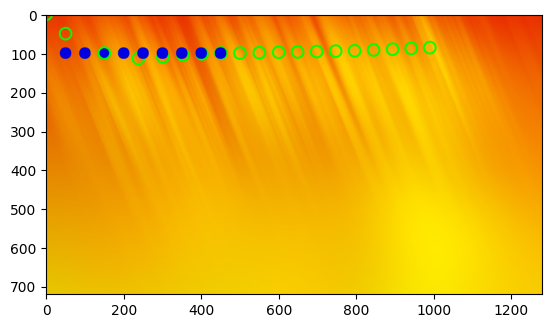

In [7]:
# Kalman Filter
kf = KalmanFilter()
 
img = cv2.imread(img_dir + "blue_background.webp")

#preannotated meaasurement for ball1  (that goes only strait and at constant velocity)
ball1_positions = [(50, 100), (100, 100), (150, 100), (200, 100), (250, 100), (300, 100), (350, 100), (400, 100), (450, 100)]

#preannotated meaasurement for ball2 (that goes on a parabola)
ball2_positions = [(4, 300), (61, 256), (116, 214), (170, 180), (225, 148), (279, 120), (332, 97),
         (383, 80), (434, 66), (484, 55), (535, 49), (586, 49), (634, 50),
         (683, 58), (731, 69), (778, 82), (824, 101), (870, 124), (917, 148),
         (962, 169), (1006, 212), (1051, 249), (1093, 290)]

ball_to_predict = ball1_positions #choose one or the other ball
preds = [] #vettore in cui memorizzo le predizioni
L = len(ball_to_predict)

for pt in ball_to_predict:
    cv2.circle(img, pt, 15, (0, 0, 225), -1) #draw circle of radius 20 filled of near red color
    predicted = kf.predict(pt[0], pt[1])
    preds.append(predicted)
    cv2.circle(img, predicted, 15, (0, 255, 0), 4) #draw circle of radius 20 thick 4 px of near green color

# continue to predict restarting from the old prediction instead of a measurement
for i in range(10):
    predicted = kf.predict(predicted[0], predicted[1])
    img = cv2.circle(img, predicted, 15, (0, 255, 0), 4)
    
    #print(predicted)
    plt.imshow(img)

 

# <font color='green'>Exercise 2</font>:
Quantify the RMSE between measurements and predictions.
Compute this using the Kalman filter with and without the acceleration in the model. Which one behaves better?

RMSE: 42.80


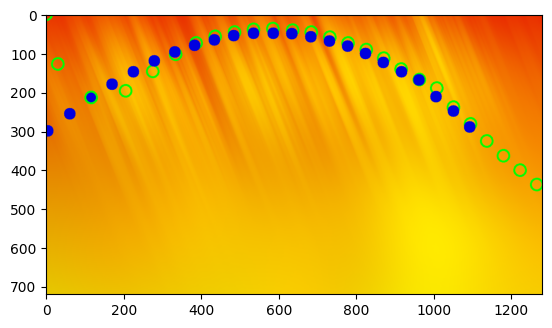

In [8]:
from sklearn.metrics import mean_squared_error as mse
kf = KalmanFilter()
 
img = cv2.imread(img_dir + "blue_background.webp")

#preannotated meaasurement for ball1  (that goes only strait and at constant velocity)
ball1_positions = [(50, 100), (100, 100), (150, 100), (200, 100), (250, 100), (300, 100), (350, 100), (400, 100), (450, 100)]

#preannotated meaasurement for ball2 (that goes on a parabola)
ball2_positions = [(4, 300), (61, 256), (116, 214), (170, 180), (225, 148), (279, 120), (332, 97),
         (383, 80), (434, 66), (484, 55), (535, 49), (586, 49), (634, 50),
         (683, 58), (731, 69), (778, 82), (824, 101), (870, 124), (917, 148),
         (962, 169), (1006, 212), (1051, 249), (1093, 290)]

ball_to_predict = ball2_positions #choose one or the other ball
preds = [] #vettore in cui memorizzo le predizioni
L = len(ball_to_predict)

for pt in ball_to_predict:
    cv2.circle(img, pt, 15, (0, 0, 225), -1) #draw circle of radius 20 filled of near red color
    predicted = kf.predict(pt[0], pt[1])
    preds.append(predicted)
    cv2.circle(img, predicted, 15, (0, 255, 0), 4) #draw circle of radius 20 thick 4 px of near green color

                                   
RMSE = mse(preds[0:L-1], ball_to_predict[1:L], squared=False)

# continue to predict restarting from the old prediction instead of a measurement
for i in range(10):
    predicted = kf.predict(predicted[0], predicted[1])
    img = cv2.circle(img, predicted, 15, (0, 255, 0), 4)
    
    #print(predicted)
    plt.imshow(img)

print ('RMSE: %.2f'% RMSE)


## <font color='green'><b> Kalman filter on a video </b></font> 

In [9]:
#function ad hoc for detecting orange (better with object detection...)
class OrangeDetector:
    def __init__(self):
        # Create range for orange color
        self.low_orange = np.array([11, 128, 90])
        self.high_orange = np.array([179, 255, 255])

    def detect(self, frame):
        hsv_img = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Create masks with color ranges
        mask = cv2.inRange(hsv_img, self.low_orange, self.high_orange)

        # Find Contours
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)

        box = (0, 0, 0, 0)
        for cnt in contours:
            (x, y, w, h) = cv2.boundingRect(cnt)
            box = (x, y, x + w, y + h)
            break

        return box

In [10]:
cap = cv2.VideoCapture(vid_dir  + "orange.mp4")
ret, frame1 = cap.read()
#create an output video:
 
I=[]
i=0
# Load detector
od = OrangeDetector()

# Load Kalman filter to predict the trajectory
kf = KalmanFilterAcc()

while True:
    ret, frame = cap.read()
    if ret is False:
        break
    i +=1
    if i ==100:
      break
    orange_bbox = od.detect(frame)
    x, y, x2, y2 = orange_bbox
    cx = int((x + x2) / 2)
    cy = int((y + y2) / 2)
 
    predicted = kf.predict(cx, cy)
  
    #cv2.rectangle(frame, (x, y), (x2, y2), (255, 0, 0), 4)
    cv2.circle(frame, (cx, cy), 20, (0, 0, 255), 4)
    cv2.circle(frame, (predicted[0], predicted[1]), 20, (255, 0, 0), 4) #predict is BLUE
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    I.append(rgb)

In [11]:
showVideo(I)

TraitError: setting max < min